In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


2025-09-16 08:21:45.101082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758010905.313197      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758010905.373283      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Down Syndrome--

In [6]:
# Input dataset paths
healthy_dir = "/kaggle/input/healthy/healthy_preprocessed_dataset"
down_dir = "/kaggle/input/capstone-dataset/down_preprocessed_dataset-20250916T043455Z-1-001/down_preprocessed_dataset"

# Output split dataset
base_dir = "/kaggle/working/split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create folders
for folder in [train_dir, val_dir, test_dir]:
    for cls in ["healthy", "down_syndrome"]:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)


In [7]:
def split_and_copy(src, class_name, split=[0.7, 0.2, 0.1]):
    all_files = os.listdir(src)

    # Split: 70% train, 20% val, 10% test
    train_files, temp_files = train_test_split(all_files, test_size=1-split[0], random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=split[2]/(split[1]+split[2]), random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(src, f), os.path.join(train_dir, class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src, f), os.path.join(val_dir, class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join(test_dir, class_name, f))

# Apply for both classes
split_and_copy(healthy_dir, "healthy")
split_and_copy(down_dir, "down_syndrome")

print("✅ Dataset split completed into train/val/test!")


✅ Dataset split completed into train/val/test!


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)

# Prefetch for speed
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


Found 1326 files belonging to 2 classes.


I0000 00:00:1758011334.808505      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758011334.809341      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 380 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


EfficientNetB0--

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# ===============================
# STEP 4: Data Augmentation
# ===============================
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# ===============================
# STEP 5: Build Model (EfficientNetB0 + Augmentation)
# ===============================
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # Freeze base layers initially

model = models.Sequential([
    layers.Rescaling(1./255),       # normalize images
    data_augmentation,              # apply augmentation
    base_model,                     # pretrained backbone
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")  # 2 classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# ===============================
# STEP 6: Train Model
# ===============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12  # you can increase to 20-30 for better performance
)

# ===============================
# STEP 7: Evaluate on Test Set
# ===============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.2f}")

# ===============================
# STEP 8: Save Model
# ===============================
model.save("/kaggle/working/efficientnet_downsyndrome_augmented.h5")

Found 1326 files belonging to 2 classes.
Found 380 files belonging to 2 classes.
Found 190 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/12


E0000 00:00:1758011356.392105      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758011359.246982     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.5155 - loss: 0.7020 - val_accuracy: 0.5158 - val_loss: 0.6928
Epoch 2/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5096 - loss: 0.7061 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 3/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5134 - loss: 0.7036 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 4/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4914 - loss: 0.7077 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 5/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5277 - loss: 0.6959 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 6/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4710 - loss: 0.7117 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 7/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5010 - loss: 0.6987 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 8/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5159 - loss: 0.6970 - val_accuracy: 0.5158 - val_loss: 

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# ================================
# 1. Data Augmentation
# ================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.02, 0.02),
], name="data_augmentation")

# ================================
# 2. Build EfficientNet Model
# ================================
IMG_SIZE = (224, 224)

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base_model.trainable = False   # freeze backbone initially

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)                   # EfficientNet expects preprocessed input
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(2, activation="softmax")(x)  # 2 classes: healthy vs down syndrome

model = models.Model(inputs, outputs)

# ================================
# 3. Compile Model
# ================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # categorical since you used label_mode="categorical"
    metrics=["accuracy"]
)

model.summary()

# ================================
# 4. Train Model
# ================================
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# ================================
# 5. Evaluate on Test Set
# ================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15


E0000 00:00:1758011952.510140      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.5729 - loss: 0.7050 - val_accuracy: 0.6684 - val_loss: 0.6382
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6697 - loss: 0.6174 - val_accuracy: 0.7000 - val_loss: 0.6007
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7143 - loss: 0.5829 - val_accuracy: 0.7000 - val_loss: 0.5743
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7288 - loss: 0.5680 - val_accuracy: 0.7079 - val_loss: 0.5531
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7799 - loss: 0.5178 - val_accuracy: 0.7211 - val_loss: 0.5350
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7736 - loss: 0.5028 - val_accuracy: 0.7289 - val_loss: 0.5231
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8059 - loss: 0.4788 - val_accuracy: 0.7237 - val_loss: 0.5187
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7892 - loss: 0.4729 - val_accuracy: 0.7368 - val_loss: 

In [12]:
from tensorflow.keras import callbacks

# ================================
# 1. Callbacks
# ================================
checkpoint_path = "/kaggle/working/best_model.h5"
cb_early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
cb_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True)

# ================================
# 2. Fine-tuning EfficientNet
# ================================
base_model.trainable = True  # unfreeze full backbone (you can also unfreeze last 50–100 layers only)

# Re-compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune for more epochs
fine_tune_epochs = 15
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[cb_early, cb_reduce, cb_checkpoint]
)

# ================================
# 3. Final Evaluation
# ================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/15


E0000 00:00:1758012197.500714      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 459ms/step - accuracy: 0.5592 - loss: 0.7213 - val_accuracy: 0.8684 - val_loss: 0.3243 - learning_rate: 1.0000e-05
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.7000 - loss: 0.5764 - val_accuracy: 0.8632 - val_loss: 0.3568 - learning_rate: 1.0000e-05
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.7738 - loss: 0.4984 - val_accuracy: 0.8526 - val_loss: 0.3821 - learning_rate: 1.0000e-05
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.8101 - loss: 0.4346 - val_accuracy: 0.8474 - val_loss: 0.3986 - learning_rate: 1.0000e-05
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.8315 - loss: 0.3904 - val_accuracy: 0.8368 - val_loss: 0.4129 - learning_rate: 5.0000e-06
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.8632 - loss: 0.3578 - val_accuracy: 0.8500 - val_loss: 0.4151 - learning_rate: 5.0000e-06
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8850 - loss: 0.32

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to your unseen image
img_path = "/kaggle/input/unseen/depositphotos_278981062-stock-photo-beautiful-young-woman-clean-fresh.jpg"

# ================================
# 1. Load & preprocess image
# ================================
IMG_SIZE = (224, 224)  # same as training
img = image.load_img(img_path, target_size=IMG_SIZE)  # load and resize
img_array = image.img_to_array(img)                   # convert to array
img_array = np.expand_dims(img_array, axis=0)         # add batch dimension
img_array = preprocess_input(img_array)               # EfficientNet preprocessing

# ================================
# 2. Predict with trained model
# ================================
pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
class_names = ["healthy", "down_syndrome"]  # must match directory order

print(f"🔍 Prediction: {class_names[class_idx]} (confidence: {pred[0][class_idx]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🔍 Prediction: healthy (confidence: 0.59)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to your unseen image
img_path = "/kaggle/input/sampletotest/OIP.jpeg"

# ================================
# 1. Load & preprocess image
# ================================
IMG_SIZE = (224, 224)  # same as training
img = image.load_img(img_path, target_size=IMG_SIZE)  # load and resize
img_array = image.img_to_array(img)                   # convert to array
img_array = np.expand_dims(img_array, axis=0)         # add batch dimension
img_array = preprocess_input(img_array)               # EfficientNet preprocessing

# ================================
# 2. Predict with trained model
# ================================
pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
class_names = ["healthy", "down_syndrome"]  # must match directory order

print(f"🔍 Prediction: {class_names[class_idx]} (confidence: {pred[0][class_idx]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
🔍 Prediction: down_syndrome (confidence: 0.51)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


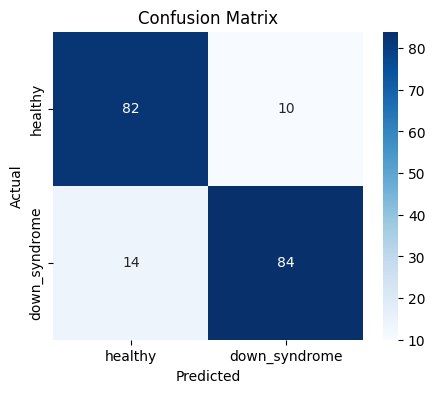

Classification Report:

               precision    recall  f1-score   support

      healthy       0.85      0.89      0.87        92
down_syndrome       0.89      0.86      0.88        98

     accuracy                           0.87       190
    macro avg       0.87      0.87      0.87       190
 weighted avg       0.87      0.87      0.87       190



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ================================
# 1. Get predictions on test set
# ================================
y_true = []
y_pred = []

class_names = ["healthy", "down_syndrome"]  # must match folder order

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # true labels
    y_pred.extend(np.argmax(preds, axis=1))            # predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ================================
# 2. Confusion Matrix
# ================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ================================
# 3. Precision, Recall, F1
# ================================
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


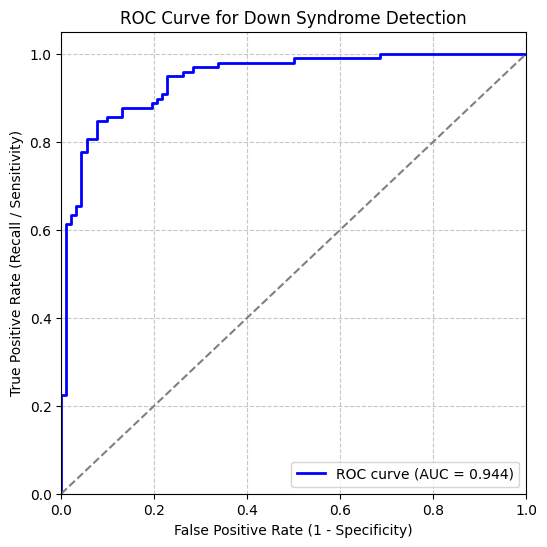

ROC AUC Score: 0.944


In [16]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# ================================
# 1. Get true labels & predicted probabilities
# ================================
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    probs = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))       # true class indices
    y_pred_probs.extend(probs[:, 1])  # probability for class "down_syndrome"

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# ================================
# 2. Compute ROC curve & AUC
# ================================
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# ================================
# 3. Plot ROC Curve
# ================================
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curve for Down Syndrome Detection")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

print(f"ROC AUC Score: {roc_auc:.3f}")


In [19]:
# Save as TensorFlow SavedModel (recommended for deployment/serving)
model.save("downsyndrome_classifier_savedmodel.keras")


In [20]:
import tensorflow as tf

IMG_SIZE = (380, 380)  # EfficientNetB4
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1326 files belonging to 2 classes.
Found 380 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


EfficientNetB4--

In [21]:
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ================================
# 1. Data Augmentation
# ================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.02, 0.02),
], name="data_augmentation")

# ================================
# 2. Compute Class Weights
# ================================
train_labels = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in train_ds.unbatch().batch(1024)])
class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

# ================================
# 3. Build EfficientNetB4 Model
# ================================
IMG_SIZE = (380, 380)
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze for initial training

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)  # 2 classes: healthy / down_syndrome

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ================================
# 4. Callbacks
# ================================
checkpoint_path = "/kaggle/working/best_model_initial.h5"
cb_early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
cb_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True)

# ================================
# 5. Initial Training
# ================================
initial_epochs = 12
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=[cb_early, cb_reduce, cb_checkpoint]
)

# ================================
# 6. Fine-tuning
# ================================
base_model.trainable = True
fine_tune_at = -80  # unfreeze last 80 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ft_checkpoint_path = "/kaggle/working/best_model_finetuned.h5"
cb_checkpoint_ft = callbacks.ModelCheckpoint(ft_checkpoint_path, monitor="val_loss", save_best_only=True)
cb_early_ft = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
cb_reduce_ft = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-8)

fine_tune_epochs = 20
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=[cb_early_ft, cb_reduce_ft, cb_checkpoint_ft]
)

# ================================
# 7. Evaluate on Test Set
# ================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ================================
# 8. Save Model
# ================================
model.save("downsyndrome_classifier.h5")                 # HDF5 format
model.save("downsyndrome_classifier.keras")             # Keras v3 format
model.save("downsyndrome_classifier_savedmodel")        # TensorFlow SavedModel
print("✅ Model saved successfully.")


Class weights: {0: 1.034321372854914, 1: 0.9678832116788321}
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,903,585 (68.30 MB)

 Trainable params: 229,762 (897.51 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

Epoch 1/12


E0000 00:00:1758013551.141333      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 429ms/step - accuracy: 0.6359 - loss: 0.6344 - val_accuracy: 0.8026 - val_loss: 0.4599 - learning_rate: 1.0000e-04
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 322ms/step - accuracy: 0.8393 - loss: 0.4240 - val_accuracy: 0.7789 - val_loss: 0.4312 - learning_rate: 1.0000e-04
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 326ms/step - accuracy: 0.8686 - loss: 0.3479 - val_accuracy: 0.8079 - val_loss: 0.3831 - learning_rate: 1.0000e-04
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 329ms/step - accuracy: 0.8747 - loss: 0.3196 - val_accuracy: 0.8184 - val_loss: 0.3745 - learning_rate: 1.0000e-04
Epoch 5/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.8721 - loss: 0.2755 - val_accuracy: 0.8000 - val_loss: 0.3844 - learning_rate: 1.0000e-04
Epoch 6/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 333ms/step - accuracy: 0.8819 - loss: 0.2885 - val_accuracy: 0.8368 - val_loss: 0.3400 - learning_rate: 1.0000e-04
Epoch 7/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.88

E0000 00:00:1758013930.572601      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 511ms/step - accuracy: 0.7846 - loss: 0.4806 - val_accuracy: 0.8211 - val_loss: 0.3886 - learning_rate: 1.0000e-05
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 414ms/step - accuracy: 0.8432 - loss: 0.3921 - val_accuracy: 0.8500 - val_loss: 0.3210 - learning_rate: 1.0000e-05
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 417ms/step - accuracy: 0.8789 - loss: 0.3105 - val_accuracy: 0.8868 - val_loss: 0.2639 - learning_rate: 1.0000e-05
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 419ms/step - accuracy: 0.8952 - loss: 0.2610 - val_accuracy: 0.9000 - val_loss: 0.2270 - learning_rate: 1.0000e-05
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 421ms/step - accuracy: 0.9033 - loss: 0.2333 - val_accuracy: 0.9105 - val_loss: 0.1969 - learning_rate: 1.0000e-05
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 421ms/step - accuracy: 0.9262 - loss: 0.2095 - val_accuracy: 0.9132 - val_loss: 0.1788 - learning_rate: 1.0000e-05
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 422ms/step - accuracy: 0.93

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=downsyndrome_classifier_savedmodel.

In [22]:
# Save as TensorFlow SavedModel (recommended for deployment/serving)
model.save("downsyndrome_classifier.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


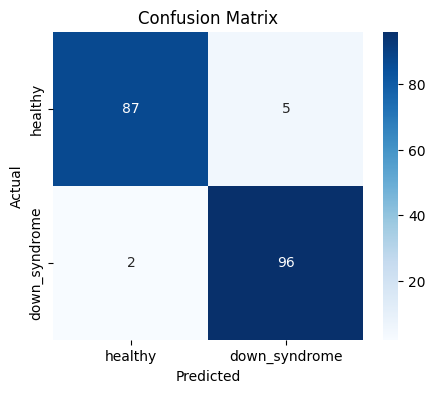

Classification Report:
                precision    recall  f1-score   support

      healthy       0.98      0.95      0.96        92
down_syndrome       0.95      0.98      0.96        98

     accuracy                           0.96       190
    macro avg       0.96      0.96      0.96       190
 weighted avg       0.96      0.96      0.96       190



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# True and predicted labels
y_true = []
y_pred = []

class_names = ["healthy", "down_syndrome"]

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


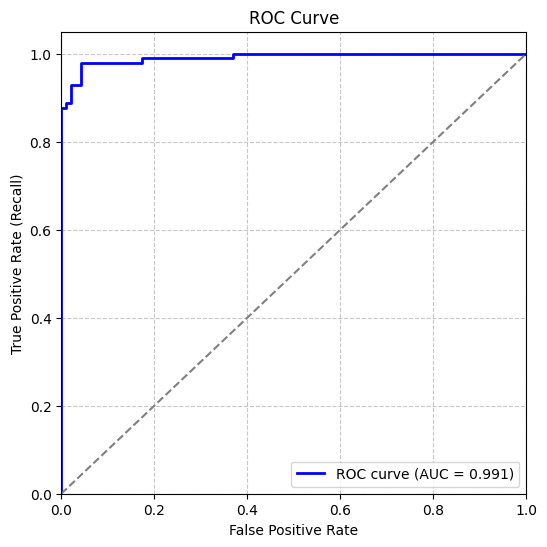

ROC AUC Score: 0.991


In [28]:
from sklearn.metrics import roc_curve, auc

# Probability for the "down_syndrome" class
y_pred_probs = []
for images, labels in test_ds:
    probs = model.predict(images)
    y_pred_probs.extend(probs[:, 1])  # down_syndrome probability

y_pred_probs = np.array(y_pred_probs)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

print(f"ROC AUC Score: {roc_auc:.3f}")


In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# ================================
# 1. Load the saved model
# ================================
model = tf.keras.models.load_model("downsyndrome_classifier.keras")
print("✅ Model loaded successfully.")

# ================================
# 2. Function to predict an unseen image
# ================================
def predict_unseen(img_path):
    IMG_SIZE = (380, 380)  # EfficientNetB4 input size
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = preprocess_input(img_array)        # preprocess for EfficientNet

    pred = model.predict(img_array)
    class_idx = np.argmax(pred, axis=1)[0]
    class_names = ["down_syndrome", "healthy"]
    
    print(f"Prediction: {class_names[class_idx]} (confidence: {pred[0][class_idx]:.2f})")
    return pred[0]

# ================================
# 3. Example usage
# ================================
unseen_image_path = "/kaggle/input/sampletotest/OIP.jpeg"  # change this to your image path
predict_unseen(unseen_image_path)


✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: down_syndrome (confidence: 0.99)


array([0.98965365, 0.01034637], dtype=float32)

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# ================================
# 1. Load the saved model
# ================================
model = tf.keras.models.load_model("downsyndrome_classifier.keras")
print("✅ Model loaded successfully.")

# ================================
# 2. Function to predict an unseen image
# ================================
def predict_unseen(img_path):
    IMG_SIZE = (380, 380)  # EfficientNetB4 input size
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = preprocess_input(img_array)        # preprocess for EfficientNet

    pred = model.predict(img_array)
    class_idx = np.argmax(pred, axis=1)[0]
    class_names = ["down_syndrome", "healthy"]
    
    print(f"Prediction: {class_names[class_idx]} (confidence: {pred[0][class_idx]:.2f})")
    return pred[0]

# ================================
# 3. Example usage
# ================================
unseen_image_path = "/kaggle/input/unseen/depositphotos_278981062-stock-photo-beautiful-young-woman-clean-fresh.jpg"  # change this to your image path
predict_unseen(unseen_image_path)


✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Prediction: healthy (confidence: 0.84)


array([0.15518442, 0.84481555], dtype=float32)

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/train",
    image_size=(380, 380),
    batch_size=16
)

print(train_ds.class_names)  # This shows the actual order used


Found 1326 files belonging to 2 classes.
['down_syndrome', 'healthy']


In [41]:
import os

autism_folder = "/kaggle/input/autism/Autism_Images/data/consolidated/Autistic"

# List all files in the folder
all_files = [f for f in os.listdir(autism_folder) if os.path.isfile(os.path.join(autism_folder, f))]

print(f"Total number of autism images: {len(all_files)}")


Total number of autism images: 1507


In [45]:
import os

autism_folder = "/kaggle/working/split_dataset/val/down_syndrome"

# List all files in the folder
all_files = [f for f in os.listdir(autism_folder) if os.path.isfile(os.path.join(autism_folder, f))]

print(f"Total number of autism images: {len(all_files)}")


Total number of autism images: 184


In [46]:
import os
import shutil
from sklearn.utils import shuffle

# ------------------------
# Paths
# ------------------------
autism_folder = "/kaggle/input/autism/Autism_Images/data/consolidated/Autistic"
split_base = "/kaggle/working/split_dataset"  # same base as previous dataset

train_dir = os.path.join(split_base, "train", "autism")
val_dir   = os.path.join(split_base, "val", "autism")
test_dir  = os.path.join(split_base, "test", "autism")

# Create directories if they don't exist
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# ------------------------
# List all images and shuffle
# ------------------------
all_files = [f for f in os.listdir(autism_folder) if os.path.isfile(os.path.join(autism_folder, f))]
all_files = shuffle(all_files, random_state=42)

# ------------------------
# Split counts
# ------------------------
train_count = 641
val_count   = 184
test_count  = 92

# ------------------------
# Copy files to respective folders
# ------------------------
for i, f in enumerate(all_files):
    src = os.path.join(autism_folder, f)
    if i < train_count:
        dst = os.path.join(train_dir, f)
    elif i < train_count + val_count:
        dst = os.path.join(val_dir, f)
    elif i < train_count + val_count + test_count:
        dst = os.path.join(test_dir, f)
    else:
        break  # ignore extra files if any
    shutil.copy(src, dst)

print(f"✅ Autism dataset split completed: {train_count} train, {val_count} val, {test_count} test")


✅ Autism dataset split completed: 641 train, 184 val, 92 test


EfficientNetB4-- (3 class)

In [49]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

In [50]:
BASE_DIR = "/kaggle/working/split_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# -------------------
# Dataset parameters
# -------------------
IMG_SIZE = (380, 380)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [51]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical"
)

# Access class names BEFORE prefetching
class_names = train_ds.class_names
print("Classes:", class_names)

Found 1967 files belonging to 3 classes.
Found 564 files belonging to 3 classes.
Found 282 files belonging to 3 classes.
Classes: ['autism', 'down_syndrome', 'healthy']


In [54]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

In [56]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.02, 0.02),
], name="data_augmentation")


In [57]:
train_labels = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in train_ds.unbatch().batch(1024)])
class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

# -------------------
# Build EfficientNetB4 model
# -------------------
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)  # 3 classes

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# -------------------
# Callbacks (unique filenames)
# -------------------
checkpoint_path = "/kaggle/working/best_model_initial_3class.h5"
cb_early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
cb_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True)

# -------------------
# Initial training
# -------------------
initial_epochs = 12
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=[cb_early, cb_reduce, cb_checkpoint]
)

# -------------------
# Fine-tuning
# -------------------
base_model.trainable = True
fine_tune_at = -80  # unfreeze last 80 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ft_checkpoint_path = "/kaggle/working/best_model_finetuned_3class.h5"
cb_checkpoint_ft = callbacks.ModelCheckpoint(ft_checkpoint_path, monitor="val_loss", save_best_only=True)
cb_early_ft = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
cb_reduce_ft = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-8)

fine_tune_epochs = 20
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=[cb_early_ft, cb_reduce_ft, cb_checkpoint_ft]
)

# -------------------
# Evaluate on Test Set
# -------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Class weights: {0: 1.0228809152366094, 1: 1.0228809152366094, 2: 0.9571776155717762}


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,903,714 (68.30 MB)

 Trainable params: 229,891 (898.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

Epoch 1/12


E0000 00:00:1758016985.734201      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_47_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.5681 - loss: 0.9049 - val_accuracy: 0.8245 - val_loss: 0.4636 - learning_rate: 1.0000e-04
Epoch 2/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - accuracy: 0.8467 - loss: 0.4358 - val_accuracy: 0.8422 - val_loss: 0.3677 - learning_rate: 1.0000e-04
Epoch 3/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 333ms/step - accuracy: 0.8851 - loss: 0.3190 - val_accuracy: 0.8404 - val_loss: 0.3413 - learning_rate: 1.0000e-04
Epoch 4/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 328ms/step - accuracy: 0.8953 - loss: 0.2747 - val_accuracy: 0.8387 - val_loss: 0.3456 - learning_rate: 1.0000e-04
Epoch 5/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.9118 - loss: 0.2472 - val_accuracy: 0.8617 - val_loss: 0.2832 - learning_rate: 1.0000e-04
Epoch 6/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.9182 - loss: 0.2253 - val_accuracy: 0.8830 - val_loss: 0.2577 - learning_rate: 1.0000e-04
Epoch 7/12
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 333ms/step - 

E0000 00:00:1758017531.294226      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_47_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


123/123 ━━━━━━━━━━━━━━━━━━━━ 101s 469ms/step - accuracy: 0.7848 - loss: 0.5702 - val_accuracy: 0.8528 - val_loss: 0.3118 - learning_rate: 1.0000e-05
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 0.8892 - loss: 0.3502 - val_accuracy: 0.8848 - val_loss: 0.2556 - learning_rate: 1.0000e-05
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 422ms/step - accuracy: 0.9137 - loss: 0.2672 - val_accuracy: 0.9220 - val_loss: 0.2025 - learning_rate: 1.0000e-05
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 424ms/step - accuracy: 0.9241 - loss: 0.2244 - val_accuracy: 0.9379 - val_loss: 0.1689 - learning_rate: 1.0000e-05
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 424ms/step - accuracy: 0.9326 - loss: 0.1896 - val_accuracy: 0.9415 - val_loss: 0.1443 - learning_rate: 1.0000e-05
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 424ms/step - accuracy: 0.9315 - loss: 0.1684 - val_accuracy: 0.9450 - val_loss: 0.1327 - learning_rate: 1.0000e-05
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 425ms/step -

In [58]:
model.save("rare_disease_classifier_3classes.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


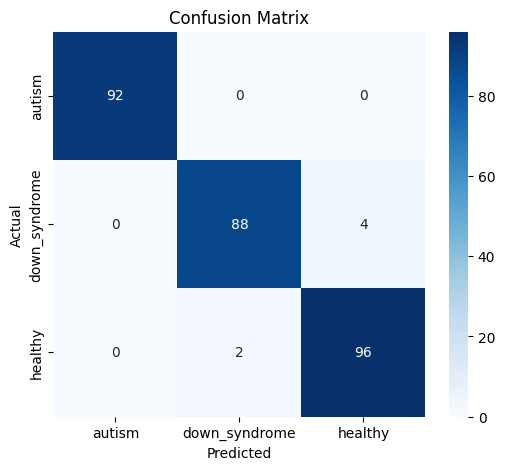

Classification Report:
                precision    recall  f1-score   support

       autism       1.00      1.00      1.00        92
down_syndrome       0.98      0.96      0.97        92
      healthy       0.96      0.98      0.97        98

     accuracy                           0.98       282
    macro avg       0.98      0.98      0.98       282
 weighted avg       0.98      0.98      0.98       282



In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# -------------------
# True and predicted labels
# -------------------
y_true = []
y_pred = []

# 3-class names in alphabetical order (match your dataset folders)
class_names = ["autism", "down_syndrome", "healthy"]

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------
# Confusion Matrix
# -------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -------------------
# Classification Report
# -------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


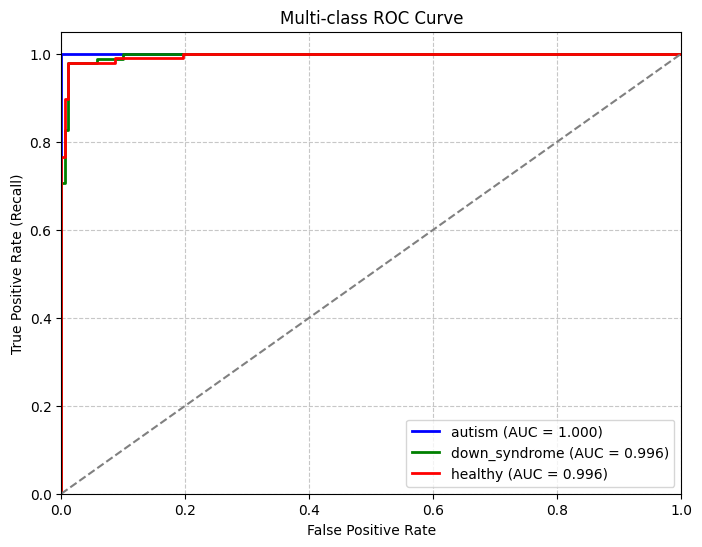

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# -------------------
# Prepare true labels and predicted probabilities
# -------------------
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    probs = model.predict(images)
    y_pred_probs.extend(probs)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0,1,2])  # 3 classes

class_names = ["autism", "down_syndrome", "healthy"]
colors = ["blue", "green", "red"]

plt.figure(figsize=(8,6))

# Compute ROC and AUC for each class (one-vs-rest)
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{cls} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# ================================
# 1. Load the saved 3-class model
# ================================
model = tf.keras.models.load_model("rare_disease_classifier_3classes.keras")
print("✅ Model loaded successfully.")

# ================================
# 2. Function to predict an unseen image
# ================================
def predict_unseen(img_path):
    IMG_SIZE = (380, 380)  # EfficientNetB4 input size
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = preprocess_input(img_array)        # preprocess for EfficientNet

    pred = model.predict(img_array)
    class_idx = np.argmax(pred, axis=1)[0]

    # Correct 3-class names
    class_names = ["autism", "down_syndrome", "healthy"]
    
    # Print predicted class and confidence
    print(f"Prediction: {class_names[class_idx]} (confidence: {pred[0][class_idx]:.2f})")
    
    # Optional: print all class probabilities
    for i, cls in enumerate(class_names):
        print(f"  {cls}: {pred[0][i]:.3f}")

    return pred[0]

# ================================
# 3. Example usage
# ================================
unseen_image_path = "/kaggle/input/unseen/depositphotos_278981062-stock-photo-beautiful-young-woman-clean-fresh.jpg"  # change this to your image path
predict_unseen(unseen_image_path)


✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: autism (confidence: 1.00)
  autism: 0.999
  down_syndrome: 0.000
  healthy: 0.001


array([9.9911934e-01, 4.5329245e-05, 8.3525531e-04], dtype=float32)

In [66]:
import os
sorted_classes = sorted(os.listdir("/kaggle/working/split_dataset/train"))
print(sorted_classes)


['autism', 'down_syndrome', 'healthy']


In [67]:
test_images = {
    "autism": "/kaggle/working/split_dataset/val/autism/0004.jpg",
    "down_syndrome": "/kaggle/working/split_dataset/val/down_syndrome/down_100.jpg",
    "healthy": "/kaggle/working/split_dataset/val/healthy/0014.jpg"
}

for cls, path in test_images.items():
    pred = predict_unseen(path)
    print(f"Actual: {cls}, Predicted: {np.argmax(pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: autism (confidence: 1.00)
  autism: 1.000
  down_syndrome: 0.000
  healthy: 0.000
Actual: autism, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: down_syndrome (confidence: 0.97)
  autism: 0.022
  down_syndrome: 0.970
  healthy: 0.009
Actual: down_syndrome, Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: autism (confidence: 0.95)
  autism: 0.946
  down_syndrome: 0.008
  healthy: 0.046
Actual: healthy, Predicted: 0
